In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def log_return(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [3]:
def log_volume(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [4]:
def bipower_variation(series, rollingWindow=5):
    '''
    Bipower Variation (BV) is the sum of the product of absolute time series returns
    :param column: price column
    :return: returns bivariate variation
    Barnhorf - Nielse & Shephard 2004 & 2006
    '''
    bv = (series.abs() *series.shift(1).abs()).dropna().rolling(rollingWindow).sum()
    
    return bv

In [5]:
def volatility_increments(series):
    theta = np.sqrt(series)
    Vt = (np.log(theta) - np.log(theta.shift(1))).dropna()
    return Vt

In [6]:
#################################################
# codes for implementing DFA-based analysis
# Exploring asymmetric multifractal cross-correlations of price-volatility and asymmetric volatility dynamics in cryptocurrency markets
#################################################
import numpy as np
import math
###########################################
# MF-ADCCA (includes DFA, DCCA, A-DFA, A-DCCA, MFDFA, MFDCCA, A-MFDFA)
##########################################

import numpy as np

def dcca(x, y, S, m, Q, trend_base=None, skip_agg=False, asymmetry_base='index'):
    """
    Calculate generalized Hurst Exponenet by Multi Fractal Detrended Cross-correlation Analysis.
    Args:
        x(array(float))  : Target time series data.
        y(array(float))  : Target time series data.
        S(array(int))    : Intervals which divides culmative sum time series. Needs to be a positive integer.
        m(int)           : Degree of polynomial fit for each divided segment. Generally, m=2 is recommended.
        Q(array(int))    : fluctuation q-th order.
        trend_base       : designated time series used for defining asymmetric trends.
        skip_agg(bool)   : Whether to use cumsum for profile. If series is stationary (ex. log-returns), then "False". If non-stationary (ex. level data), then "True".
                           It's not needed.
        asymmetry_base  : Which criterion used for defining asymmetric trends.
    Returns:
        array(float)     : Return generalized Hurst exponent (in np.array) of each Q-th order.
    """
    N = len(x)
    assert len(y) == N, '{} segments'.format(len(y))
    if skip_agg:
        X = np.copy(x)
        Y = np.copy(y)
    else:
        X = np.cumsum(x - np.mean(x))
        Y = np.cumsum(y - np.mean(y))

    def Fvs2(v, s, reverse=False):
        """
        (Root Mean Square) ** 2
        F(s, v)
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment_x = X[N - (v-Ns)*s:N - (v-Ns)*s+s]
            segment_y = Y[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment_x = X[(v-1)*s:v*s]
            segment_y = Y[(v-1)*s:v*s]
        coef_x = np.polyfit(ax, segment_x, m)
        coef_y = np.polyfit(ax, segment_y, m)
        fitting_x = np.polyval(coef_x, ax)
        fitting_y = np.polyval(coef_y, ax)
        return np.mean(np.abs(segment_x - fitting_x)*np.abs(segment_y - fitting_y)) # DCCA for x and y

    if asymmetry_base == 'index':
        x_alt = np.exp(np.cumsum(x)) # index-based
    elif asymmetry_base == 'return':
        x_alt = np.copy(x) # return-based
    elif asymmetry_base == 'optional':
        assert type(trend_base) == np.ndarray, 'trend_base is None. designate trend_base.'
        x_alt = np.copy(trend_base) # only for optional. Any series is possible, but designate trend_base.
    else:
        print('not available: index or return or optional only\nPlease choose either and try again')

    def asym_trend(v, s, reverse=False):
        """
        Detecting trend in some data series H
        L_H(x)=a_H+b_H x
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment = x_alt[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment = x_alt[(v-1)*s:v*s]
        coef = np.polyfit(ax, segment, 1) # m=1, y=ax+b (a,b)
        return coef[0] # represents a in y=ax+b

    Fhq = np.zeros(len(Q))
    Fhq_plus = np.zeros(len(Q))
    Fhq_minus = np.zeros(len(Q))
    
    for i, q in enumerate(Q):
        Fqs = np.zeros(len(S))
        Fqs_plus = np.zeros(len(S))
        Fqs_minus = np.zeros(len(S))

        for j, s in enumerate(S):
            Ns = int(N//s)
            segs = np.array([
                [Fvs2(v, s) for v in range(1, Ns + 1)],
                [Fvs2(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(segs) == 2 * Ns, '{} segments'.format(len(segs))

            trend_segs = np.array([
                [asym_trend(v, s) for v in range(1, Ns + 1)],
                [asym_trend(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(trend_segs) == 2 * Ns, '{} segments'.format(len(trend_segs))

            M_plus = np.sum((1+np.sign(trend_segs))/2)
            M_minus = np.sum((1-np.sign(trend_segs))/2)

            # calculate qth fluctuation function
            if q == 0:
                # asymmetric version
                Fqs_plus[j] = np.exp((np.sum(((1+np.sign(trend_segs))/2)*np.log(segs))/M_plus)/2)
                Fqs_minus[j] = np.exp((np.sum(((1-np.sign(trend_segs))/2)*np.log(segs))/M_minus)/2)
                # overall
                Fqs[j] = np.exp(np.mean(np.log(segs))/2)
            else:
                # asymmetric version
                Fqs_plus[j] = (np.sum(((1+np.sign(trend_segs))/2)*(segs ** (q/2))) /M_plus)**(1/q)
                Fqs_minus[j] = (np.sum(((1-np.sign(trend_segs))/2)*(segs ** (q/2)))/M_minus)**(1/q)
                # overall version
                Fqs[j] = np.mean(segs ** (q/2)) ** (1/q)

        coef_plus = np.polyfit(np.log(S), np.log(Fqs_plus), 1)
        coef_minus = np.polyfit(np.log(S), np.log(Fqs_minus), 1)
        coef = np.polyfit(np.log(S), np.log(Fqs), 1)
        Fhq_plus[i] = coef_plus[0]
        Fhq_minus[i] = coef_minus[0]
        Fhq[i] = coef[0]

    # 1~2: estimates for overall trend, 4~5: estimates for positive trend, 7~8: estimates for negative trend
    # S: scales, Fqs: fluctuation functions, Fhq: generalized hurst exponent
    return S, Fqs, Fhq, S, Fqs_plus, Fhq_plus, S, Fqs_minus, Fhq_minus

def basic_dcca(x, y, Q, m=2, trend_base=None, skip_agg=False, observations=100, asymmetry_base='index'):
    """
    polynominal fitting is set to m = 2 at default
    """
    N = len(x)
    s_min = max(20, int(np.floor(N/100)))
    s_max = min(20*s_min, int(np.floor(N/10)))
    s_inc = (s_max - s_min) / (observations-1)
    S = [s_min + int(np.floor(i*s_inc)) for i in range(0, observations)]
    return dcca(x, y, S=S, m=m, Q=Q, trend_base=trend_base, skip_agg=skip_agg, asymmetry_base=asymmetry_base)

def nonlinear_detrend(segment, degree=2):
    """
    Nonlinear detrending using local polynomial regression.
    Args:
        segment (np.array): Segment of the time series.
        degree (int): Degree of the polynomial regression (e.g., 2 for quadratic).
    Returns:
        np.array: Detrended segment.
    """
    n = len(segment)
    x = np.arange(n)
    
    # Fit a polynomial regression
    coefficients = np.polyfit(x, segment, degree)
    
    # Calculate the trend using the polynomial coefficients
    trend = np.polyval(coefficients, x)
    
    # Remove the trend from the segment
    detrended_segment = segment - trend
    
    return detrended_segment

def MFADCCA_Hurst(X, Y, T=252, step=1, Q=np.array([2]), trend_base=None, skip_agg=False, observations=100, asymmetry_base='return'):
    X = np.array(X)
    nX = X.shape[0]
    hurst = np.zeros(nX-T+1)
    hurst_plus = np.zeros(nX-T+1)
    hurst_minus = np.zeros(nX-T+1)
    
    for i in range(0, nX-T+1, step):
        XX = X[i:i+T]
        YY = Y[i:i+T]
        
        # Apply nonlinear detrending to the segments
        XX_detrended = nonlinear_detrend(XX)
        YY_detrended = nonlinear_detrend(YY)
        
        MFADCCA_Hurst = basic_dcca(XX_detrended, YY_detrended, Q=Q, trend_base=trend_base, skip_agg=skip_agg, observations=observations, asymmetry_base=asymmetry_base)
        hurst[i] = MFADCCA_Hurst[2]
        hurst_plus[i] = MFADCCA_Hurst[5]
        hurst_minus[i] = MFADCCA_Hurst[8]
    
    return hurst, hurst_plus, hurst_minus



In [7]:
# read data_set and split them
dataset = pd.read_csv(r"./Datasets/HSI/HSI_QPL.csv")
df = dataset.reset_index(drop=True)
df = df.head(2515)

Close = df['Close']
Volume = df['vol']
# compute Log return and bipower variation for MFADCCA
LogReturn = log_return(Close)         # X
Bv = bipower_variation(LogReturn)     # Y
Vt = volatility_increments(Bv)
vol =  log_volume(Volume) 

Q = np.array([2])

df['log_returns'] = LogReturn         # add to df
df['volatility_increments'] = Vt
df['log_volumes'] = vol

In [8]:
data = df.dropna(axis=0, how='any')

r = data["log_returns"]
v = data["volatility_increments"]
vol = data['log_volumes']

data

Unnamed: 0        Date      Open      High       Low     Close  \
7            7.0   2010/1/13  21990.68  22012.04  21688.17  21748.60   
8            8.0   2010/1/14  21871.01  21988.93  21707.10  21716.95   
9            9.0   2010/1/15  21715.09  21788.85  21581.07  21654.16   
10          10.0   2010/1/18  21418.34  21645.68  21320.97  21460.01   
11          11.0   2010/1/19  21481.11  21681.69  21335.60  21677.98   
...          ...         ...       ...       ...       ...       ...   
1968      1968.0  2017/12/19  29193.74  29339.11  29144.17  29253.66   
1969      1969.0  2017/12/20  29199.29  29326.52  29159.28  29234.09   
1970      1970.0  2017/12/21  29209.64  29431.81  29145.13  29367.06   
1971      1971.0  2017/12/22  29505.05  29578.01  29413.86  29578.01   
1972      1972.0  2017/12/27  29632.97  29693.82  29516.51  29597.66   

            QPLp1        QPLp2        QPLp3        QPLp4  ...       QPLn16  \
7     22043.41273  22167.37609  22321.37769  22494.30177  ...  19043.19137   
8     21923.45577  22046.74454  22199.90808  22371.89114  ...  18939.56117   
9     21767.16188  21889.57172  22041.64334  22212.40032  ...  18804.53968   
10    21469.70028  21590.43732  21740.43079  21908.85427  ...  18547.56413   
11    21532.62080  21653.71168  21804.14473  21973.06180  ...  18601.92084   
...           ...          ...          ...          ...  ...          ...   
1968  29263.74537  29428.31300  29632.75791  29862.32337  ...  25280.79976   
1969  29269.30867  29433.90760  29638.39137  29868.00048  ...  25285.60588   
1970  29279.68349  29444.34076  29648.89701  29878.58751  ...  25294.56863   
1971  29575.80187  29742.12439  29948.74941  30180.76287  ...  25550.38378   
1972  29704.02862  29871.07224  30078.59309  30311.61244  ...  25661.15821   

           QPLn17       QPLn18       QPLn19       QPLn20       QPLn21   vol  \
7     18828.77437  18615.08363  18402.38140  18190.89718  17980.83158  3.41   
8     18726.31099  18513.78312  18302.23838  18091.90503  17882.98258  2.34   
9     18592.80978  18381.79703  18171.76041  17962.92654  17755.49351  2.66   
10    18338.72765  18130.59852  17923.43218  17717.45215  17512.85382  1.87   
11    18392.47233  18183.73325  17975.95977  17769.37608  17564.17815  1.91   
...           ...          ...          ...          ...          ...   ...   
1968  24996.15035  24712.46507  24430.09211  24149.33611  23870.46341  1.68   
1969  25000.90235  24717.16314  24434.73650  24153.92712  23875.00140  1.35   
1970  25009.76419  24725.92440  24443.39765  24162.48874  23883.46415  1.49   
1971  25262.69898  24975.98861  24690.60453  24406.85466  24125.00818  1.32   
1972  25372.22615  25084.27273  24797.65137  24512.67129  24229.60285  1.78   

      log_returns  volatility_increments  log_volumes  
7       -0.026231              -0.073208     0.438255  
8       -0.001456              -0.006423    -0.376561  
9       -0.002895              -0.011364     0.128175  
10      -0.009006               0.055760    -0.352388  
11       0.010106               0.161583     0.021165  
...           ...                    ...          ...  
1968     0.006972              -0.033817    -0.005935  
1969    -0.000669              -0.190234    -0.218689  
1970     0.004538              -0.075585     0.098672  
1971     0.007158               0.036122    -0.121144  
1972     0.000664              -0.284896     0.298982  

[1966 rows x 52 columns]

In [9]:
hurst, hurst_plus, hurst_minus = MFADCCA_Hurst(r, vol, T=256, step=1, Q=Q, trend_base=None, skip_agg=False, observations=100, asymmetry_base='return')

In [10]:
hurst.shape

(1711,)

In [11]:
data['hurst'] = pd.DataFrame(np.array([0] * 1711))
data['hurstp'] = pd.DataFrame(np.array([0] * 1711))
data['hurstm'] = pd.DataFrame(np.array([0] * 1711))

data = data.tail(1711)

data['hurst'] = hurst
data['hurstp'] = hurst_plus
data['hurstm'] = hurst_minus
data = data.reset_index(drop = True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_37476\3102487100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurst'] = pd.DataFrame(np.array([0] * 1711))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37476\3102487100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurstp'] = pd.DataFrame(np.array([0] * 1711))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_37476\3102487100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [12]:
data.to_csv(r'./Datasets/HSI/HSI_nlMFADCCA.csv')

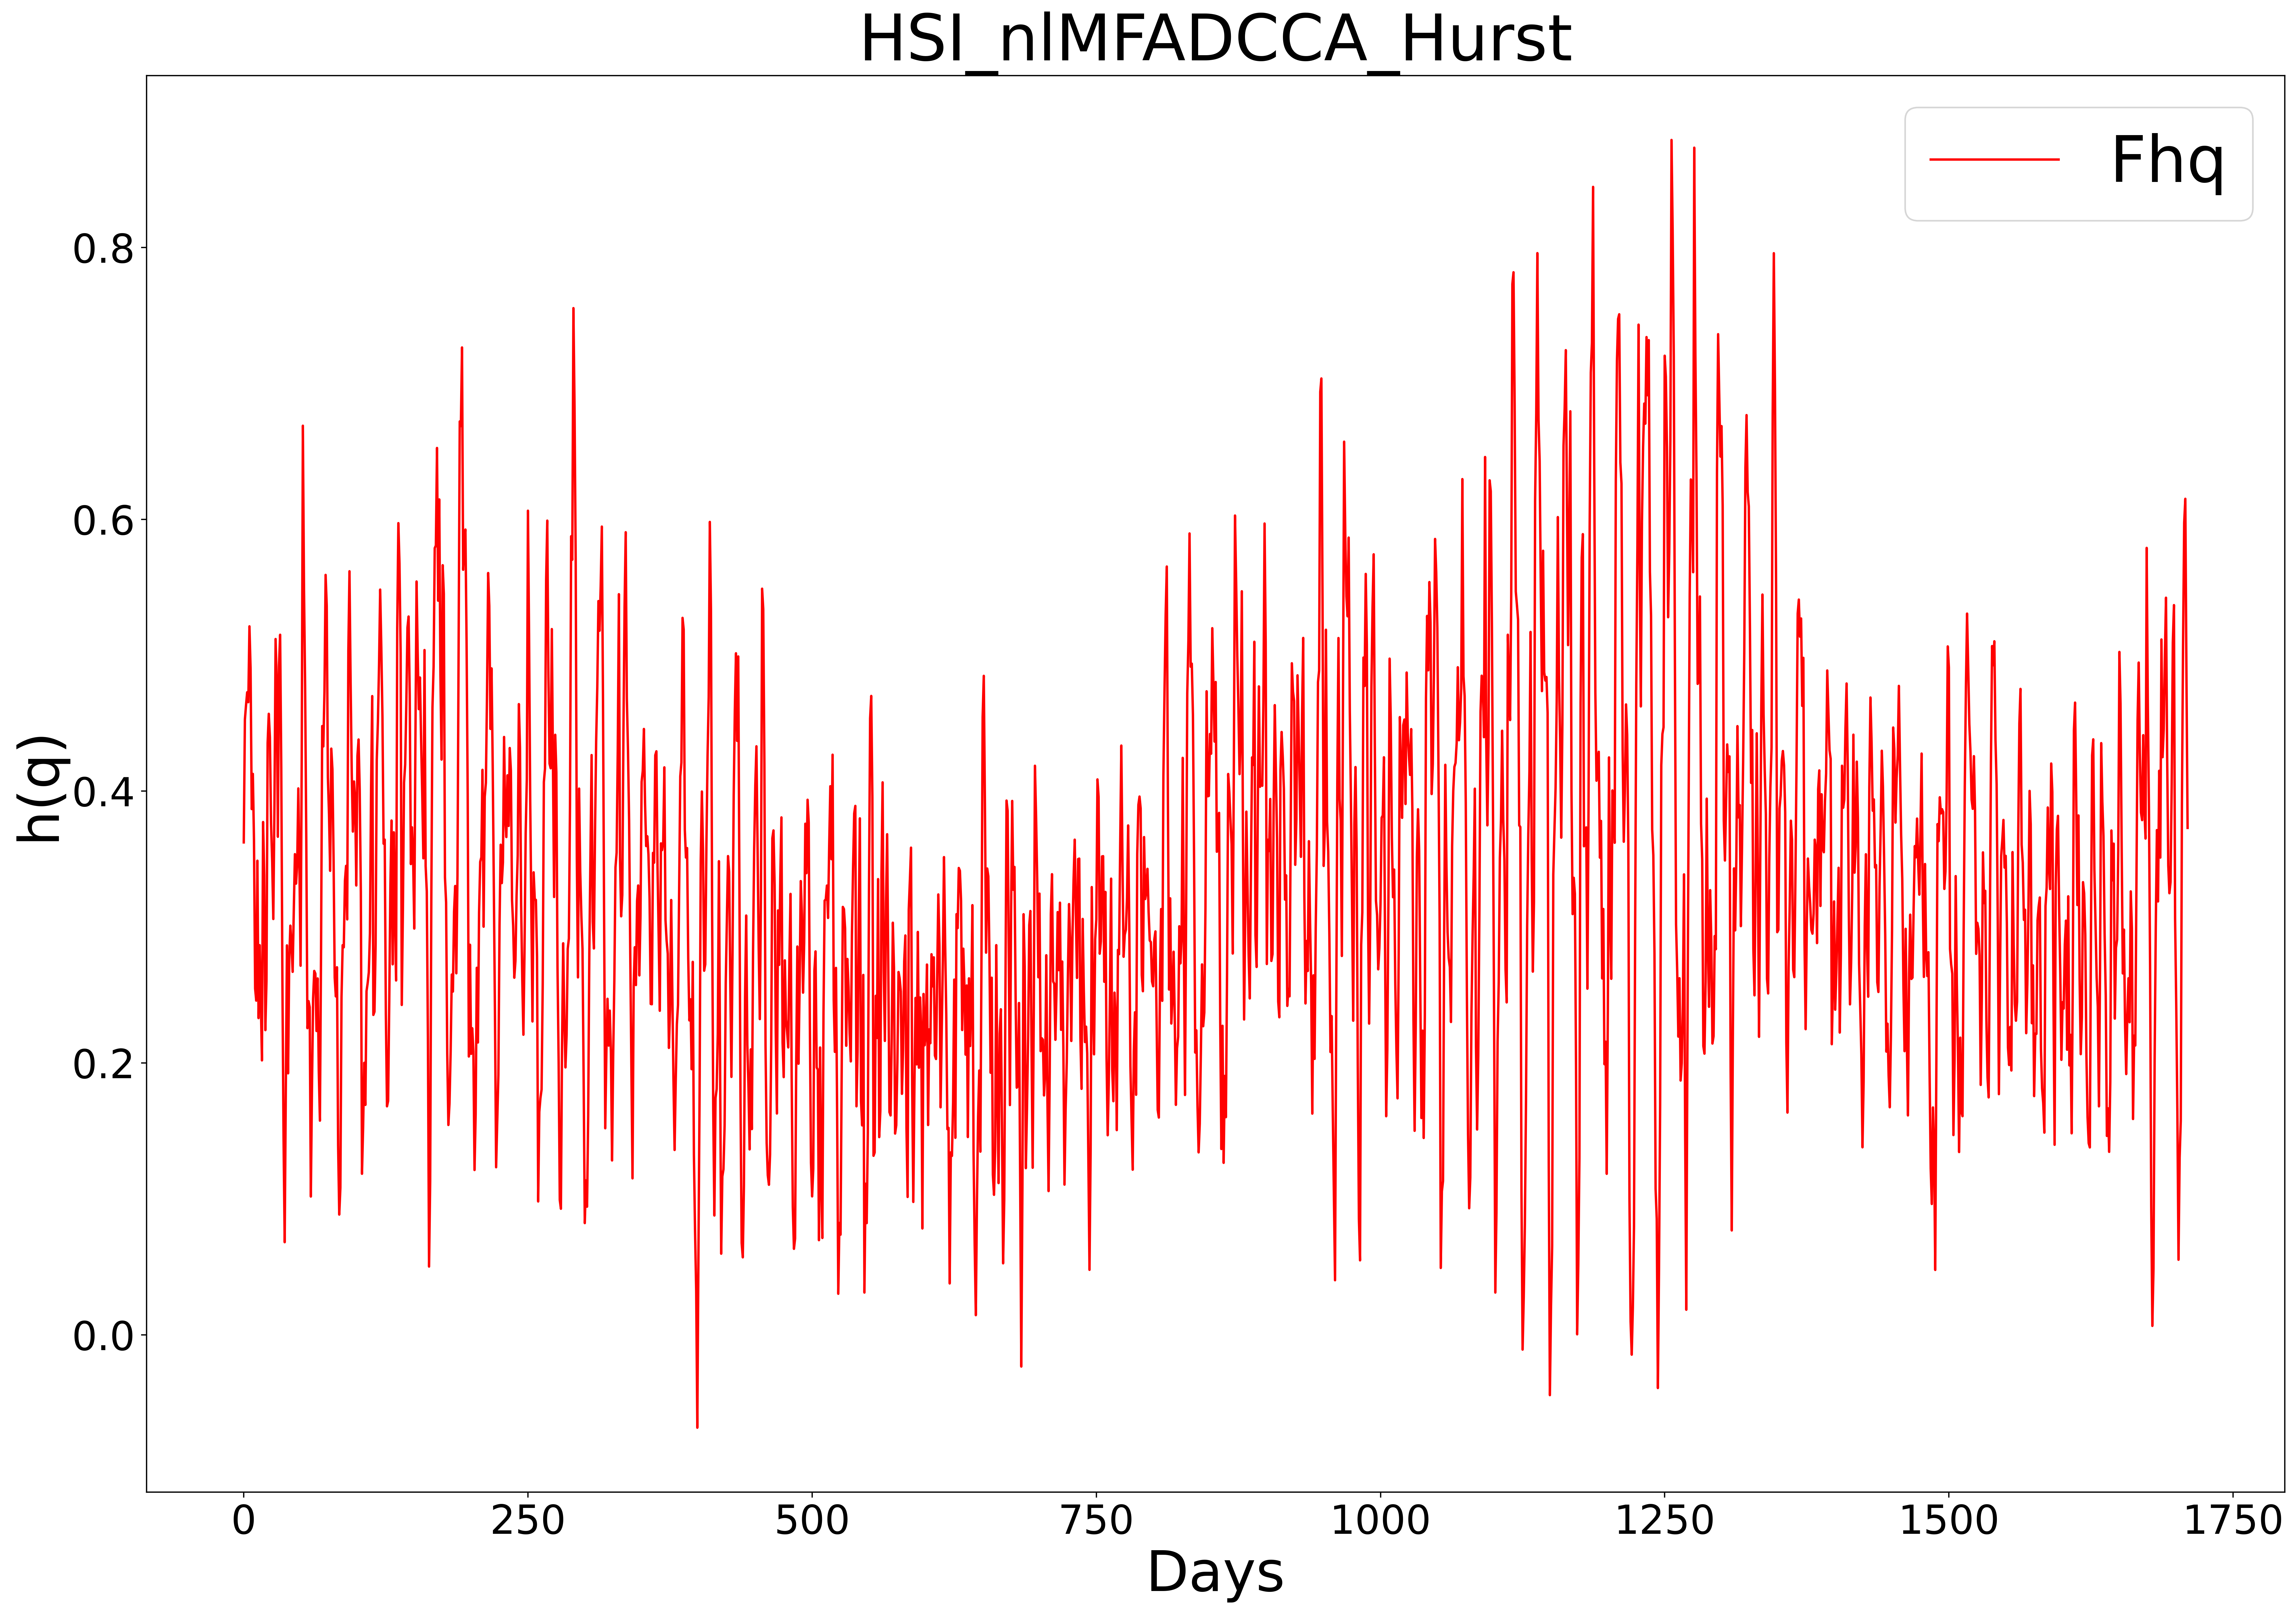

In [13]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst,color='r')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('HSI_nlMFADCCA_Hurst', fontsize=40)
plt.legend(['Fhq'],fontsize=40)
plt.savefig('./pic/HSI_pic/HSI_nlMFADCCA_hurst.png')
plt.show()

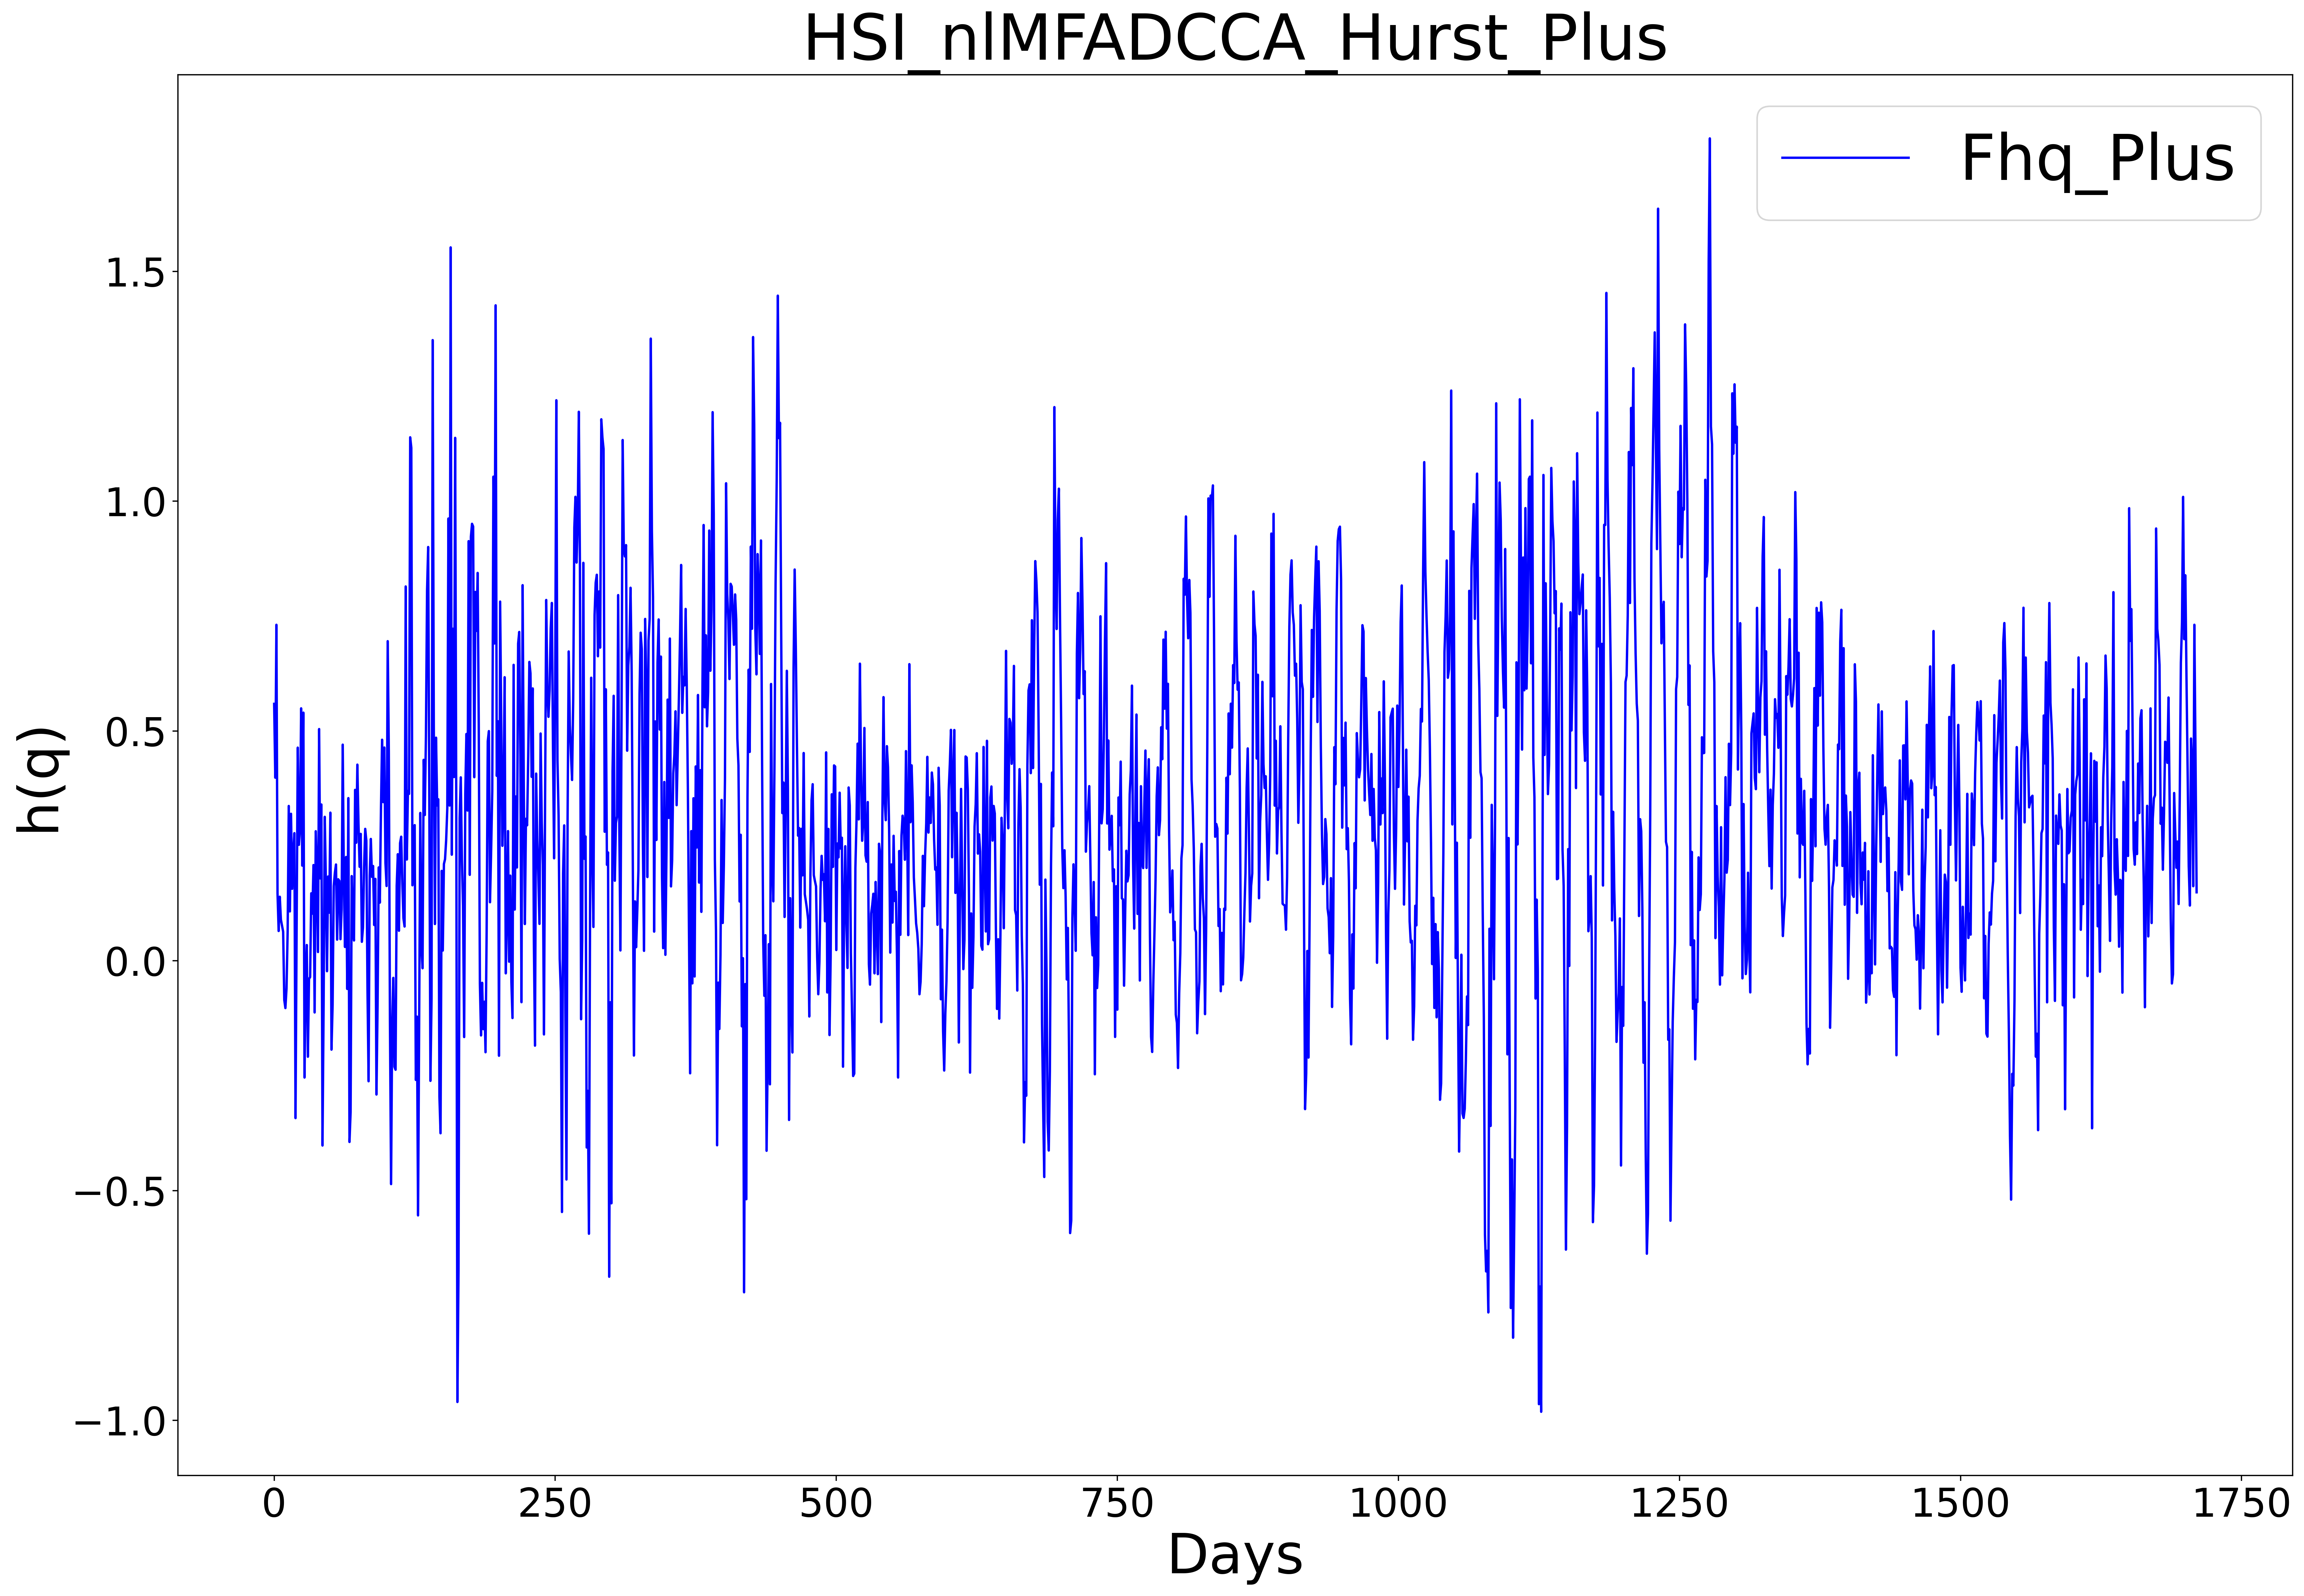

In [14]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_plus,color='b')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('HSI_nlMFADCCA_Hurst_Plus', fontsize=40)
plt.legend(['Fhq_Plus'],fontsize=40)
plt.savefig('./pic/HSI_pic/HSI_nlMFADCCA_hurstplus.png')
plt.show()

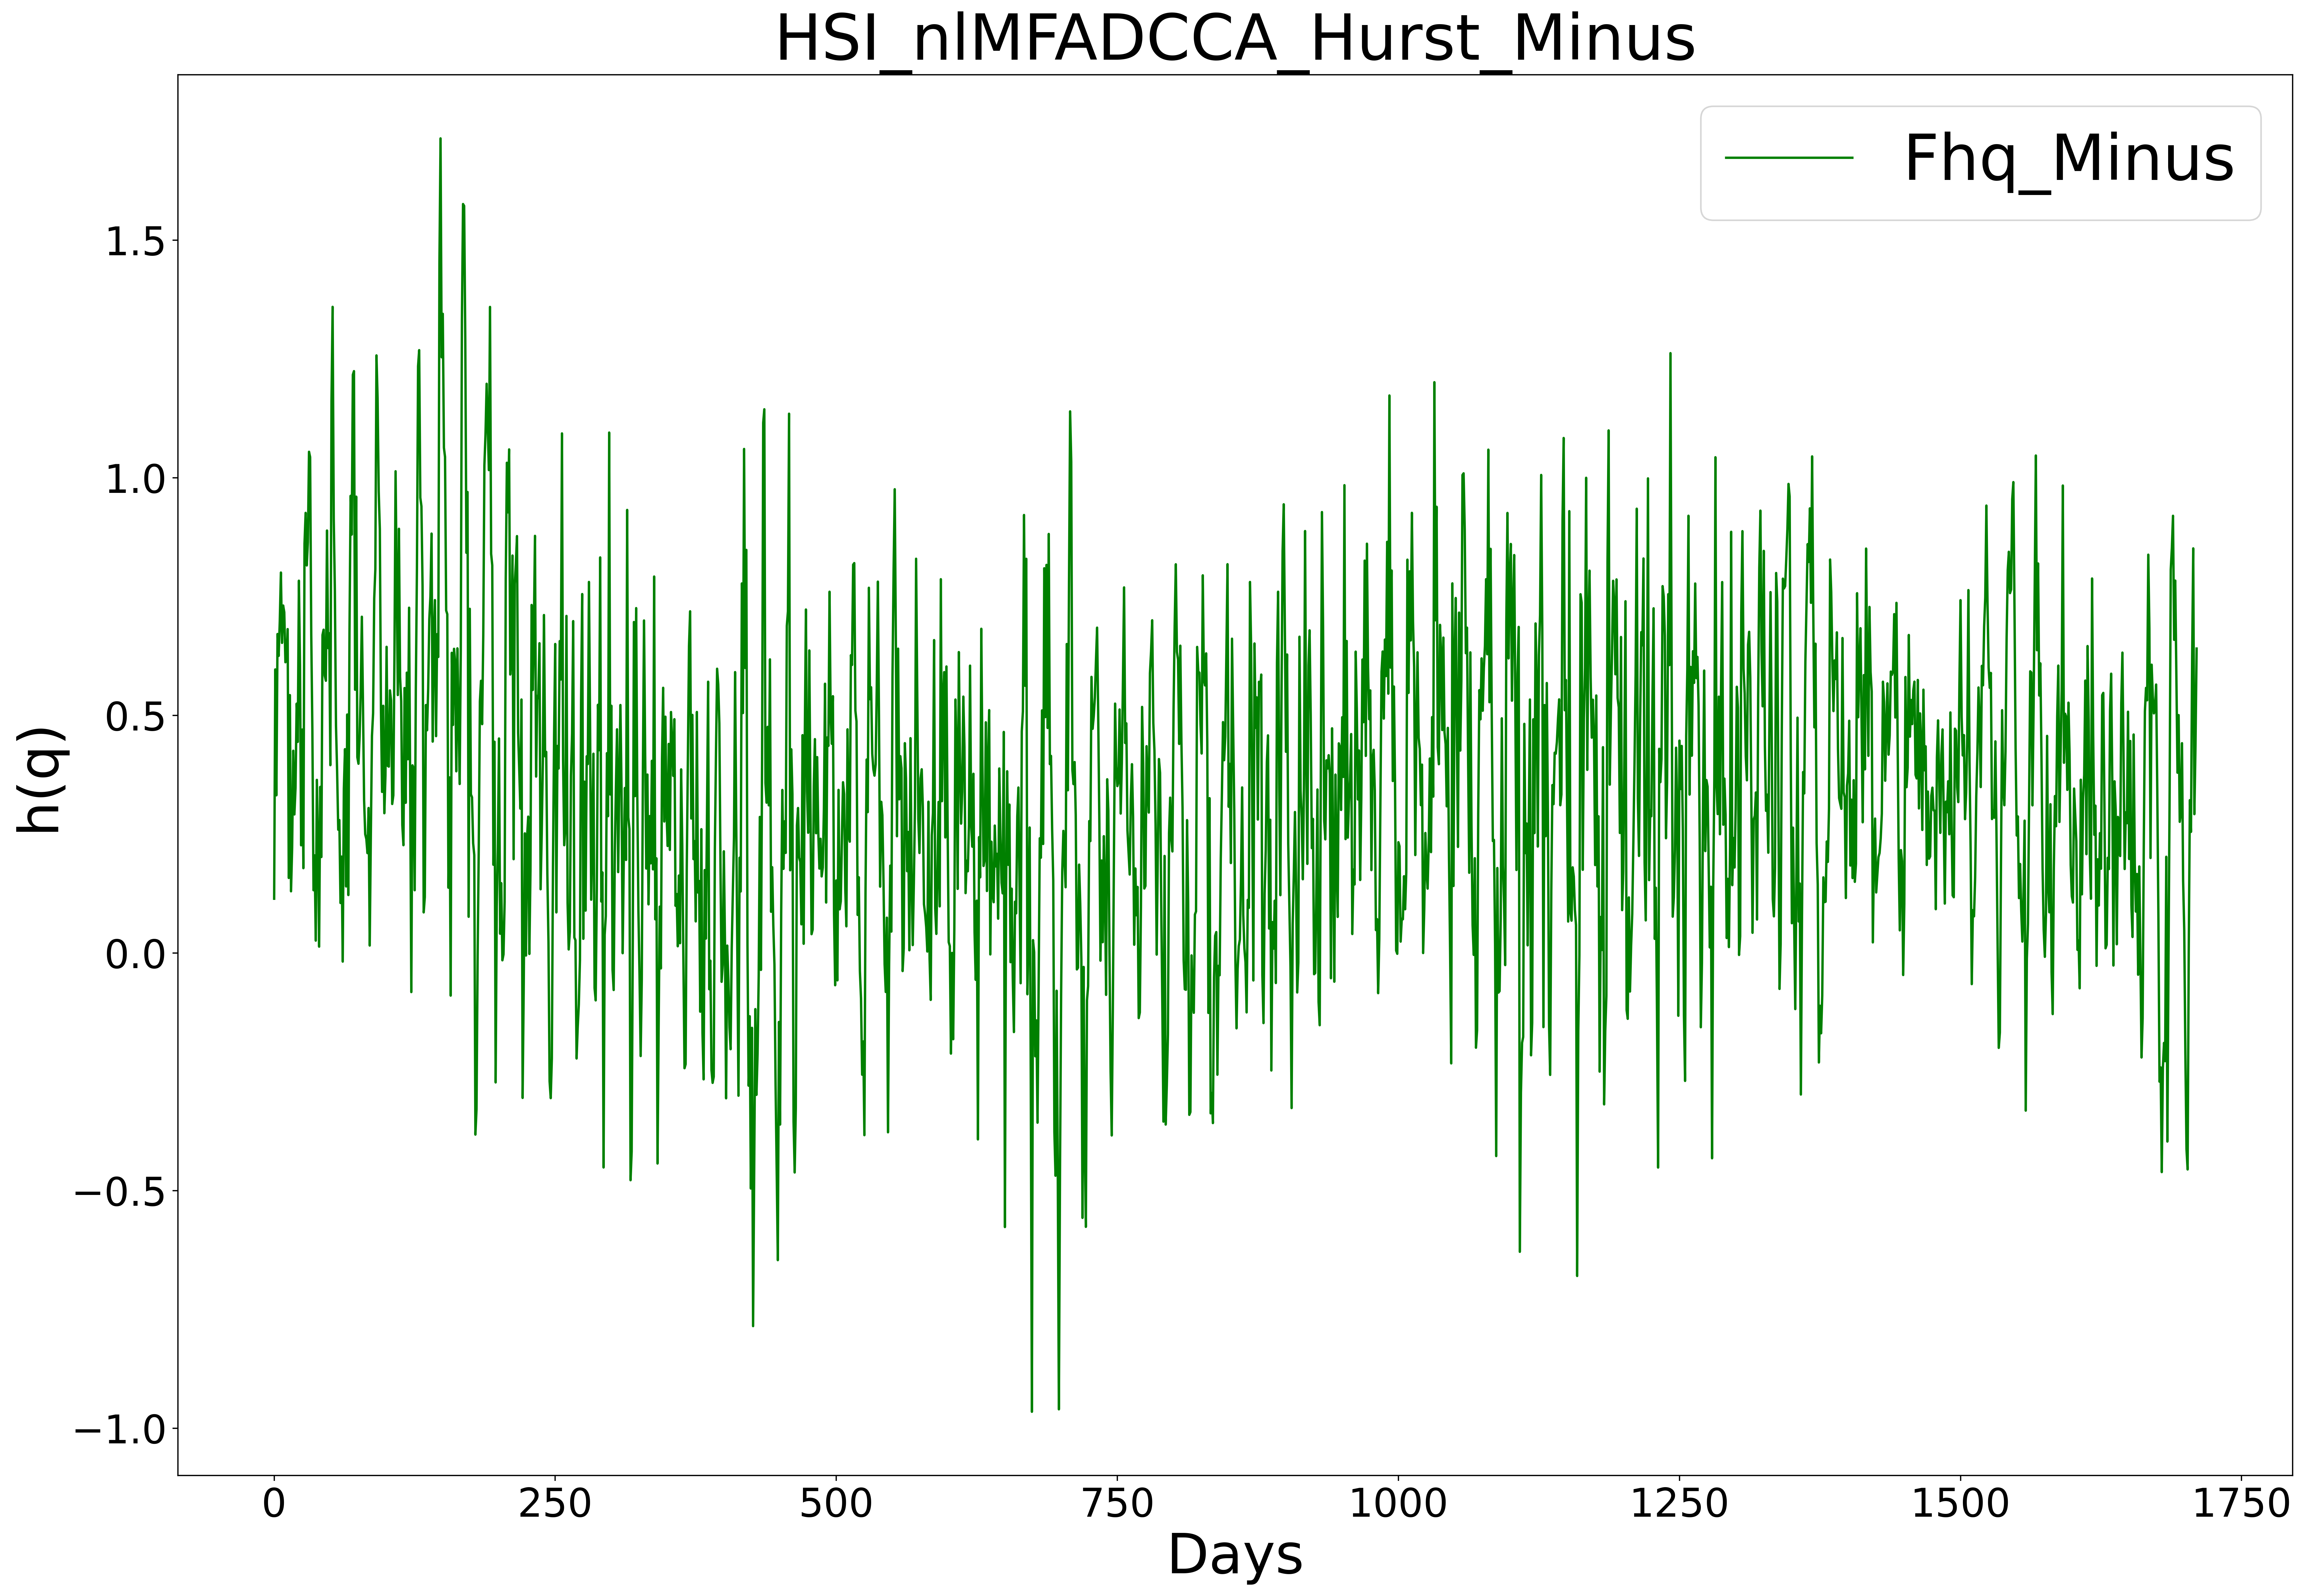

In [15]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_minus,color='g')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('HSI_nlMFADCCA_Hurst_Minus', fontsize=40)
plt.legend(['Fhq_Minus'],fontsize=40)
plt.savefig('./pic/HSI_pic/HSI_nlMFADCCA_hurstminus.png')
plt.show()